In [2]:
import scanpy as sc
import scvelo as scv
import anndata2ri
from rpy2.rinterface_lib import callbacks
callbacks._WRITECONSOLE_EXCEPTION_LOG = "    %s"
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
adata=sc.read("adata_satglia.h5ad")
adata_glia=sc.read("../SS2/data/adata_assigned.h5ad")
adata_raw=sc.read("../SS2/data/adata_glia_raw.h5ad")
adata_raw=adata_raw[adata_glia.obs_names]
adata_sat=adata.raw.to_adata()

In [4]:
adata_raw.obs=adata_glia.obs

In [5]:
%%R -i adata_sat -i adata_raw
library(Seurat)
adata_sat <- as.Seurat(adata_sat,counts="X",data = "X")
adata_glia <- as.Seurat(adata_raw,counts="X",data = "X")
p2_sat=pagoda2::basicP2proc(adata_sat@assays$RNA@counts,n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)
p2_glia=pagoda2::basicP2proc(adata_glia@assays$RNA@counts,n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

creating space of type angular done
adding data ... done
building index ... done
querying ... done
creating space of type angular done
adding data ... done
building index ... done
querying ... done


In [6]:
%%R -o graph_conn -o members -o assignments_proj -o proj_names
library(conos)
panel<-list(p2_glia,p2_sat)
names(panel)<-c("glia","sat")
con <- Conos$new(panel, n.cores=1)
con$buildGraph(k=15, k.self=5, space='PCA',ncomps=20)

graph_conn <- igraph::as_adjacency_matrix(con$graph, attr="weight")
members = colnames(graph_conn)

milestones=adata_glia@meta.data$assignments
names(milestones)=colnames(adata_glia)
assignments_proj <- con$propagateLabels(labels = milestones, verbose=FALSE)
proj_names <- names(assignments_proj$labels)

...

In [7]:
import pandas as pd
members=pd.Series(members)

glia_members=members[members.str.contains("SS2")]
sat_members=members[~members.str.contains("SS2")]
graph_conn=graph_conn[sat_members.index,:][:,glia_members.index]
glia_members.reset_index(drop=True,inplace=True)
sat_members.reset_index(drop=True,inplace=True)

In [10]:
import numpy as np
np.sum(graph_conn[0,:].A[0])

11.323214948177338

In [13]:
graph_conn[0,:].A

array([[0.73885506, 0.74518412, 0.76260483, ..., 0.        , 0.        ,
        0.        ]])

In [7]:
import numpy as np
umap=np.asarray(adata_glia[glia_members].obsm["X_umap"])
proj_umap=list(map(lambda i: [np.nansum((graph_conn[i,:].A*umap[:,0])[0]/np.sum(graph_conn[i,:].A[0])),
                              np.nansum((graph_conn[i,:].A*umap[:,1])[0]/np.sum(graph_conn[i,:].A[0]))],
                   range(graph_conn.shape[0])))

adata_sat.obsm["X_umap"]=pd.DataFrame(proj_umap,index=sat_members).loc[adata_sat.obs_names].values

In [8]:
assignments_proj=pd.Series(assignments_proj.rx("labels")[0],index=proj_names)

In [9]:
adata.obs["assignments_proj"]=assignments_proj[adata.obs_names].values

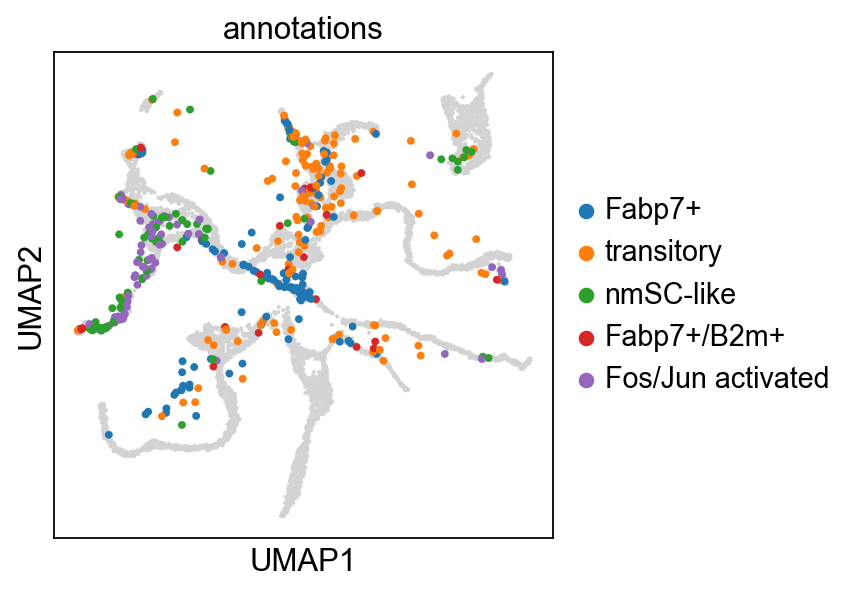

In [22]:
sc.set_figure_params()
ax=sc.pl.umap(adata_glia,show=False)
sc.pl.umap(adata_sat[adata_sat.obsm["X_umap"].sum(axis=1)!=0],s=50,color="annotations",ax=ax)

array([False, False, False, ..., False,  True, False])

In [23]:
umap=pd.DataFrame(adata_sat.obsm["X_umap"],index=adata.obs_names)

In [30]:
umap.loc[umap.sum(axis=1)!=0].to_csv("UMAP_projected.csv")

In [11]:
adata.uns["assignments_proj_colors"]=adata_glia.uns["assignments_colors"]

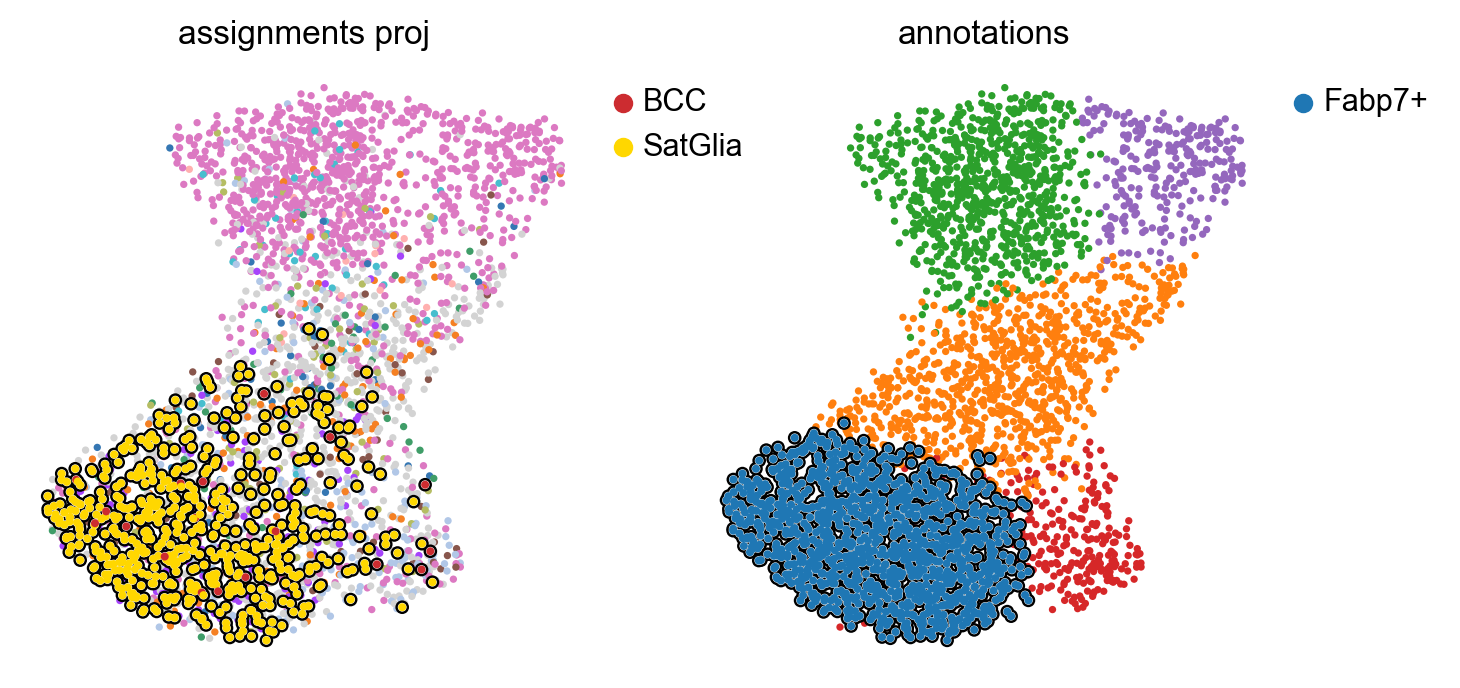

In [12]:
scv.set_figure_params(figsize=(4,4))
scv.pl.scatter(adata,color=["assignments_proj","annotations"],add_outline=["BoundaryCap","Fabp7+","BCC","SatGlia"],legend_loc="upper right")

In [13]:
adata.write("adata_projected.h5ad")